<a href="https://colab.research.google.com/github/shaikadish/twitterTopicModeling/blob/main/twitterTopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd drive/MyDrive/twitterTopicModeling

Mounted at /content/drive
/content/drive/MyDrive/twitterTopicModeling


In [65]:
def get_conversation_query_params(conversation_id, max_result=5000):
    return  {'query': 'conversation_id:{}'.format(conversation_id),
            'tweet.fields': 'author_id,conversation_id,created_at,in_reply_to_user_id,lang,referenced_tweets',
            'user.fields': 'id,created_at,username,name,description,location,public_metrics,url,verified,entities',
            'expansions': 'author_id,in_reply_to_user_id,referenced_tweets.id',
            'max_results': max_result
            }

def get_tweet_query_params():
    return  {
            'tweet.fields': 'author_id,conversation_id,created_at,in_reply_to_user_id,lang,referenced_tweets',
            'user.fields': 'id,created_at,username,name,description,location,public_metrics,url,verified,entities',
            'expansions': 'author_id,in_reply_to_user_id,referenced_tweets.id',
            }

def get_followers_query_params(max_results = 100):
    return {'user.fields': 'id,created_at,username,name,description,location,public_metrics,url,verified,entities',
            'max_results':max_results}

def get_user_query_params():
    return {'user.fields':'id,created_at,username,name,description,location,public_metrics,url,verified,entities'}

def get_recent_search_query_params(search_query,start_time,end_time, max_results = 100):

    return {'query': f"{search_query} lang:en -is:retweet",
            #'granularity': granularity,
            'start_time': start_time,
            'end_time': end_time,
            'user.fields': 'id,created_at,username,name,description,location,public_metrics,url,verified,entities',
            'tweet.fields': 'author_id,in_reply_to_user_id,created_at,conversation_id,public_metrics,lang,geo,referenced_tweets,entities',
            'expansions': 'author_id',
            'max_results': max_results}

In [238]:
import json
import os
import time

import requests
import dateutil.parser as parser

bearer_token = 'AAAAAAAAAAAAAAAAAAAAAMp9TQEAAAAAmH4NuulUuo2z0lX5kaHfD4yU6u8%3Dq0Z1rZjc9GBkc7sssQ8ni1eyYz7DDtPjnWRSUxAb8iqnubyH10'
headers = {"Authorization": "Bearer {}".format(bearer_token)}

def count_recent_tweets(search_query, granularity='day', start_time=None, end_time=None) -> dict:
    url = "https://api.twitter.com/2/tweets/counts/recent"
    if start_time:
       start_time = parser.parse(start_time).isoformat()+'Z'
    if end_time:
        end_time = parser.parse(end_time).isoformat()+'Z'

    params = {'query': search_query,
              'granularity': granularity,
              'start_time': start_time,
              'end_time': end_time}
    return requests.request("GET", url, headers=headers, params=params).json()


def recent_search_lookup(search_query,granularity='day', start_time=None, end_time=None, max_count = 50) -> dict:
    url = "https://api.twitter.com/2/tweets/search/recent"

    if start_time:
       start_time = parser.parse(start_time).isoformat()+'Z'
    if end_time:
        end_time = parser.parse(end_time).isoformat()+'Z'

    params = get_recent_search_query_params('#'+' #'.join(search_query),start_time,end_time)
    all_responses = []
    response = requests.request("GET", url, headers=headers, params = params).json()
    all_responses.extend(response['data'])
    time.sleep(2)
    id_list=[]
    
    while 'next_token' in response['meta'] and len(all_responses) < max_count:
        params['next_token'] = response['meta']['next_token']
        response = requests.request("GET", url, headers=headers, params = params).json()
        
        time.sleep(2)
        '''
        for r in response['data']:
          follower_count=get_user_profile(r['author_id'])
          print(follower_count)
          time.sleep(4)
          if follower_count['data']['public_metrics']['followers_count']>500:
            data_copy.append(r)
        
        response['data']=data_copy
        '''
          
        all_responses.extend(response['data'])

    return all_responses

def conversation_lookup(conversation_id, timeout=2) -> dict:
    params = query_params.get_conversation_query_params(conversation_id)
    url = 'https://api.twitter.com/2/tweets/search/recent'
    results = requests.request("GET", url, headers=headers, params=params).json()
    time.sleep(timeout)
    if results['meta']['result_count'] == 0:
        return
    new_results = results.copy()
    while 'next_token' in new_results['meta']:
        params['next_token'] = new_results['meta']['next_token']
        new_results = requests.request("GET", url, headers=headers, params=params).json()
        results['data'].extend(new_results['data'])
        results['includes']['users'].extend(new_results['includes']['users'])
        if 'tweets' in new_results['includes']:
            results['includes']['tweets'].extend(new_results['includes']['tweets'])
        time.sleep(timeout)
    return results

def tweet_lookup(tweet_id, timeout=2) -> dict:
    url = 'https://api.twitter.com/2/tweets/{}'.format(tweet_id)
    params = query_params.get_tweet_query_params()
    time.sleep(timeout)
    return requests.request("GET", url, headers=headers, params=params).json()


def get_user_profile(user_id, update = False, timeout=6):
    url = "https://api.twitter.com/2/users/{}".format(user_id)    
    params = get_user_query_params()
    response = requests.request("GET", url, headers=headers, params = params).json()
    return response


def followers_lookup(user_id):
    url = "https://api.twitter.com/2/users/{}/followers".format(user_id)
    params = query_params.get_followers_query_params()

    all_responses = []
    response = requests.request("GET", url, headers=headers, params = params).json()
    all_responses.append(response)
    time.sleep(60)
    while 'next_token' in response['meta']:
        next_token = response['meta']['next_token']
        query_params['pagination_token'] = next_token
        response = requests.request("GET", url, headers=headers, params = params).json()
        all_responses.append(response)
        time.sleep(60)

    return all_responses

In [239]:
import json
import datetime

from requests.api import get
from datetime import datetime


def get_tweets(hashtags: list,
               period: int):
    """
    A function to retrieve all tweets from a historical period.
    
    :param hashtags: The list of hashtags to search for
    :param period: The number of days before today to search for tweets
    """
    today=datetime.now()
    today=today.strftime("%m/%d/%Y") # Currently taking from midnight to midnight, could do some messing around to get it to be current
    begin_period=today.split('/')
    if int(begin_period[1])<=period:
        begin_period[0]=str(int(begin_period[0])-1)
        begin_period[1]=str(31-period)
    else:
        begin_period[1]=str(int(begin_period[1])-period)
    begin_period='/'.join(begin_period)
    return recent_search_lookup(hashtags,start_time=begin_period,end_time=today,max_count=300)
 
a=get_tweets(['f1'],5)

In [226]:
a

[{'author_id': '1107546556100734977',
  'conversation_id': '1528525755893817344',
  'created_at': '2022-05-22T23:58:33.000Z',
  'entities': {'annotations': [{'end': 11,
     'normalized_text': 'Lando Norris',
     'probability': 0.9884,
     'start': 0,
     'type': 'Person'}],
   'hashtags': [{'end': 91, 'start': 82, 'tag': 'formula1'},
    {'end': 95, 'start': 92, 'tag': 'f1'},
    {'end': 103, 'start': 96, 'tag': 'f1news'}],
   'urls': [{'display_url': 'f1chronicle.com/lando-norris-o…',
     'end': 81,
     'expanded_url': 'https://f1chronicle.com/lando-norris-overcomes-illness-for-points-finish/?utm_source=twitter&utm_medium=social&utm_campaign=ReviveOldPost',
     'start': 58,
     'url': 'https://t.co/qOdUdc1rMx'}]},
  'id': '1528525755893817344',
  'lang': 'en',
  'public_metrics': {'like_count': 1,
   'quote_count': 0,
   'reply_count': 0,
   'retweet_count': 0},
  'text': 'Lando Norris Overcomes Illness For Fighting Points Finish https://t.co/qOdUdc1rMx #formula1 #f1 #f1news'}

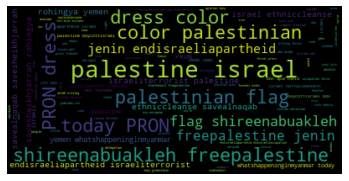

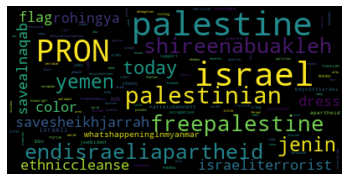

In [5]:
import spacy
from wordcloud import WordCloud
import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def clean_text(text,nlp):
    #nlp = spacy.load("en_core_web_sm")
    stops=nlp.Defaults.stop_words
    stops |= {'.','-','?','_','!','...','-',':',',',';','\"','&',']','[','(',')','\''}
    text=text.lower()
    text=remove_emoji(text)
    doc = nlp(text)
    lemmatized=list()
    for word in doc:
        if '@' in word.text:
            continue
        if '#' in word.text:
            continue
        if 'https' in word.text:
            continue
        lemma=word.lemma_.strip()
        if lemma:
            if lemma not in stops:
                lemmatized.append(lemma)
    return " ".join(lemmatized)


def show_wordcloud(text: list,
                   pos: list):
    """
    A function to display a wordcloud of one or more parts of speech.
    
    :param text: The list of tweet texts
    :param pos: One or more parts of speech tags to include in the wordcloud
    """
    #Generate a word cloud image
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40,collocations=False).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    # Cool stuff goes here

tweets=get_tweets(['Israel','Palestine'],1)
text=[]
nlp = spacy.load("en_core_web_sm")
for tweet in tweets:
    text.append(clean_text(tweet['text'],nlp))
corpus=" ".join(text)
docs=list(nlp.pipe(text))
show_wordcloud(corpus,[1])

In [ ]:
!pip install sentence_transformers
!pip install pysentimiento

In [ ]:
!pip install pyyaml==5.4.1

In [ ]:
!pip install umap-learn

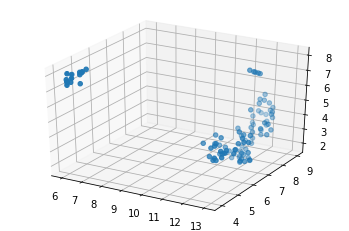

In [232]:
from matplotlib.pyplot import get
import numpy as np
import spacy
from sentence_transformers import SentenceTransformer
import umap
from pysentimiento.preprocessing import preprocess_tweet
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd


def get_tweet_embedding(text):
    """
    A function to embed a set of tweets into an embedding space.
    
    :param text: The list of tweet texts
    :return: The set of embedding vectors
    """
    model=SentenceTransformer('distilbert-base-nli-mean-tokens')
    embedding=[]
    for tweet in text:
        embedding.append(model.encode(tweet))
    embedding=np.array(embedding)
    return embedding

def visualise_embedding(vectors):
    """
    A function to reduce and visualise an embedding space.
    
    :param vectors: A set of vectors to visualise
    """
    fit=umap.UMAP(n_components=3,n_neighbors=15,metric='cosine')
    ax=plt.axes(projection='3d')
    reduced_data=fit.fit_transform(vectors)
    ax.scatter3D(reduced_data[:,0],reduced_data[:,1],reduced_data[:,2])
    fig=px.scatter_3d(pd.DataFrame(reduced_data),x=0,y=1,z=2)
    fig.show()

def get_text(tags=['f1']):
    tweets=get_tweets(tags,6)
    text=[]
    #nlp = spacy.load("en_core_web_sm")
    stops={'emoji','url','@usuario','usuario'}
    for tweet in tweets:
        new_text=' '.join(preprocess_tweet(tweet['text'],lang="en").lower().split('\n'))
        new_text=' '.join([word for word in new_text.split(' ') if  not(word in stops)])
        text.append(new_text)
    return text

visualise_embedding(get_tweet_embedding(get_text()))

In [ ]:
!pip install hdbscan

In [240]:
text=get_text(tags=['f1'])
tweet_embeddings=get_tweet_embedding(text)

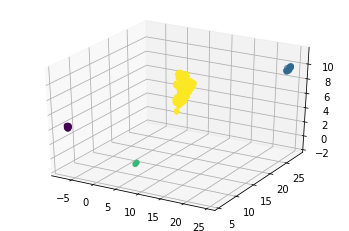

In [297]:
import numpy as np
import umap
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt

def get_topics(vectors):
    """
    A function to uncover the topics present in a text embedding.
    
    :param vectors: A set of embedding vectors
    :return: The uncovered topics and their associated scores
    """
    fit=umap.UMAP(n_components=5,n_neighbors=15,metric='cosine')
    reduced_data=fit.fit_transform(vectors)
    cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(reduced_data)
    fit=umap.UMAP(n_components=3,n_neighbors=15,metric='cosine')
    reduced_data=fit.fit_transform(vectors)
    result=pd.DataFrame(reduced_data,columns=['x','y','z'])
    result['labels']=cluster.labels_
    clustered=result.loc[result.labels!=-1]
    ax=plt.axes(projection='3d')
    ax.scatter3D(clustered.x,clustered.y,clustered.z,c=clustered.labels)
    # Cool stuff goes here
    
    return cluster.labels_

def get_topic_clusters(tweet_embeddings):
    return get_topics(tweet_embeddings)

labels=get_topic_clusters(tweet_embeddings)

In [298]:
data={'tweet':text,'label':labels}
df=pd.DataFrame(data=data)
df[df['label']==3]

,tweet,label
0,lando norris overcomes illness for fighting po...,3
1,[reddit formula dank] found this and thought o...,3
2,person number 3431 who would win in any merced...,3
3,f1 so they hate eachother lol? its just the fa...,3
4,russell is now the only driver to have scored ...,3
...,...,...
295,max check mark button (takes championship le...,3
296,[race fans] vote for your 2022 spanish grand p...,3
297,the exception that i would take is that rules ...,3
298,sir lewis hamilton appreciation tweet. this m...,3


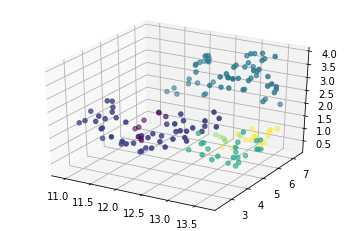

In [299]:
data={'tweet':text,'label':labels}
df=pd.DataFrame(data=data)
new_text=pd.Series(text)[df.label==3].to_list()
new_vectors=tweet_embeddings[df.label==3]
new_labels=get_topic_clusters(new_vectors)

In [302]:
data={'tweet':new_text,'label':new_labels}
new_df=pd.DataFrame(data=data)
new_df[new_df.label==2]

,tweet,label
0,lando norris overcomes illness for fighting po...,2
7,fire check out the latest podcast episode of ...,2
9,what a day of sport!!! lufc pgachampionship f1,2
12,[f1 chronicle] 2022 spanish grand prix review ...,2
15,aggressive strategy pays off for valtteri bott...,2
23,chocolattea2news httpurl motogp f1,2
24,my driver of the year already! purple heart ...,2
25,mclaren confirm lando norris battled through t...,2
29,your sunday night with speed city starts in 30...,2
30,do you know which drivers don't make good team...,2


In [ ]:
def get_sentiment(text: str) -> float:
    """
    A function to predict the sentiment of a piece of text.
    
    :param text: The text
    :return: The sentiment score
    """
    tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
    model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
    inputs=tokenizer(text,return_tensors='pt')
    outputs=model(**inputs) # output [NEG,NEU,POS]
    # Cool stuff goes here
    
    return [i.item() for i in outputs.logits[0]]